## 卷积神经网络的应用

欢迎来到课程4的第二项作业！在此笔记本中，你将：
- 实现模型构建所需的辅助函数
- 使用TensorFlow实现功能全面的ConvNet

**完成此作业后，你将能够**：
- 用TensorFlow构建和训练ConvNet解决分类问题

我们在这里假设你已经熟悉TensorFlow。如果不是，请先学习课程2第三周的TensorFlow教程（“改善深度神经网络”）。

### 1 TensorFlow模型
在上一项作业中，你使用numpy构建了辅助函数，以了解卷积神经网络背后的机制。实际上现在大多数深度学习的应用都是使用编程框架构建的，框架具有许多内置函数，你可以轻松地调用它们。

和之前一样，我们将从加载包开始。

In [46]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from tensorflow.python.framework import ops
from cnn_utils import *
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow as tf2

%matplotlib inline
np.random.seed(1)


运行以下单元格以加载要使用的“SIGNS”数据集。

In [35]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

SIGNS数据集是6个手势符号的图片集，这些符号表示从0到5的数字。

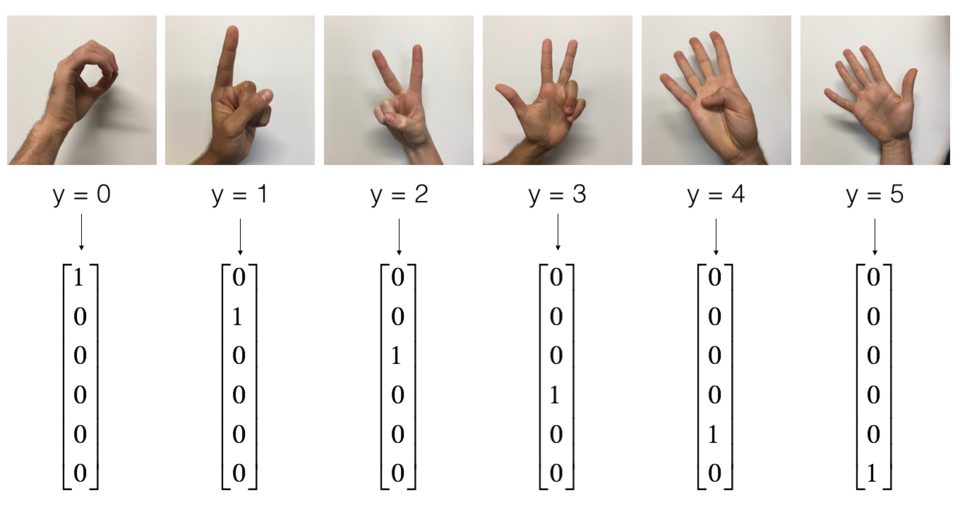

以下单元格将显示数据集中标记图像的示例。随时更改index的值，然后重新运行以查看不同的示例。

y = 2


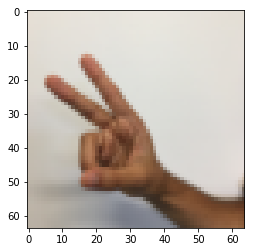

In [36]:
# Example of a picture
index = 6
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

在课程2中，你已经为此数据集构建了一个全连接的网络。但是由于这是图像数据集，因此应用ConvNet将更自然。

首先，让我们检查数据的维度。

In [37]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


#### 1.1 创建占位符
TensorFlow需要为运行会话时输入的数据创建占位符。

**练习**：实现以下函数为输入图像X和输出Y创建占位符。暂时不用定义训练数据的数量。为此，你可以使用 "None" 作为批次大小，稍后灵活地选择它。因此，X的维度应为 [None, n_H0, n_W0, n_C0]，Y的尺寸应为 [None, n_y]。 提示。

In [38]:
# GRADED FUNCTION: create_placeholders

def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    ### START CODE HERE ### (≈2 lines)
    X = tf.compat.v1.placeholder(tf.float32, shape=(None, n_H0, n_W0, n_C0))
    Y = tf.compat.v1.placeholder(tf.float32,shape=(None,n_y))
    ### END CODE HERE ###
    
    return X, Y

In [39]:
X, Y = create_placeholders(64, 64, 3, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder_2:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_3:0", shape=(?, 6), dtype=float32)


- 我：注意，这里可能因为安装的是tf2会报错“AttributeError: module 'tensorflow' has no attribute 'placeholder'”，这时候就要参考[文章](http://t.csdn.cn/CXCCa),修改对应位置的代码（本例的报错代码在函数中）
    - 问问问：很奇怪，我在代码一开始就统一降级了，不知道为什么这里还要单独降级，猜测是因为开头的统一降级失败了。

**预期输出**

X = Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)

Y = Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)



#### 1.2 初始化参数
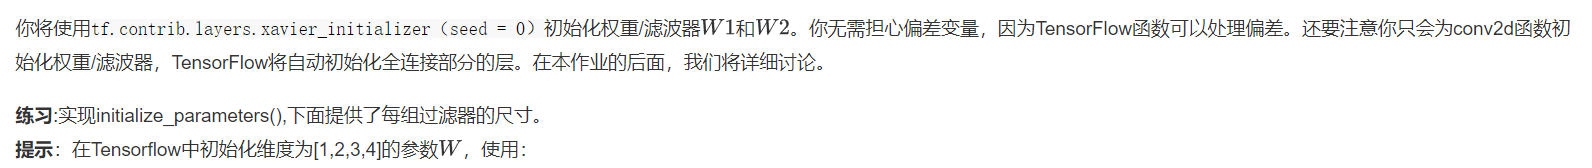

```
W = tf.get_variable("W", [1,2,3,4], initializer = ...)
```


In [48]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.set_random_seed(1)                              # so that your "random" numbers match ours
        
    ### START CODE HERE ### (approx. 2 lines of code)
    W1 =tf.get_variable('W1',[4,4,3,8],initializer=tf2.initializers.GlorotUniform(seed = 0))
    W2 = tf.get_variable('W2',[2,2,8,16],initializer=tf2.initializers.GlorotUniform(seed = 0))
    ### END CODE HERE ###
    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [49]:
tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1 = " + str(parameters["W1"].eval()[1,1,1]))
    print("W2 = " + str(parameters["W2"].eval()[1,1,1]))

W1 = [-0.05346771  0.18349849 -0.01215445  0.00138046  0.0012947  -0.02904211
 -0.11260509 -0.143055  ]
W2 = [-0.1713624   0.09527719 -0.0744766  -0.02245569  0.24450928 -0.06879854
  0.21546292 -0.08803296 -0.16513646 -0.19527972 -0.22957063  0.15745944
  0.13090086 -0.12304181 -0.05287278  0.03434092]


- 我：代码可能会报错“ module 'tensorflow.compat.v1' has no attribute 'contrib'”，参考[解决方案](http://t.csdn.cn/Ospm0);我这里相当于同时引入了tf1和tf2
    我：这里写的`tf.disable_v2_behavior()`是会让tf中的tensorflow2的行为失效；不会让tf2中的tensorflow2的行为失效

**预期输出**:

W1 = [ 0.00131723 0.1417614 -0.04434952 0.09197326 0.14984085 -0.03514394
-0.06847463 0.05245192]

W2 = [-0.08566415 0.17750949 0.11974221 0.16773748 -0.0830943 -0.08058
-0.00577033 -0.14643836 0.24162132 -0.05857408 -0.19055021 0.1345228
-0.22779644 -0.1601823 -0.16117483 -0.10286498]

#### 1.3 正向传播

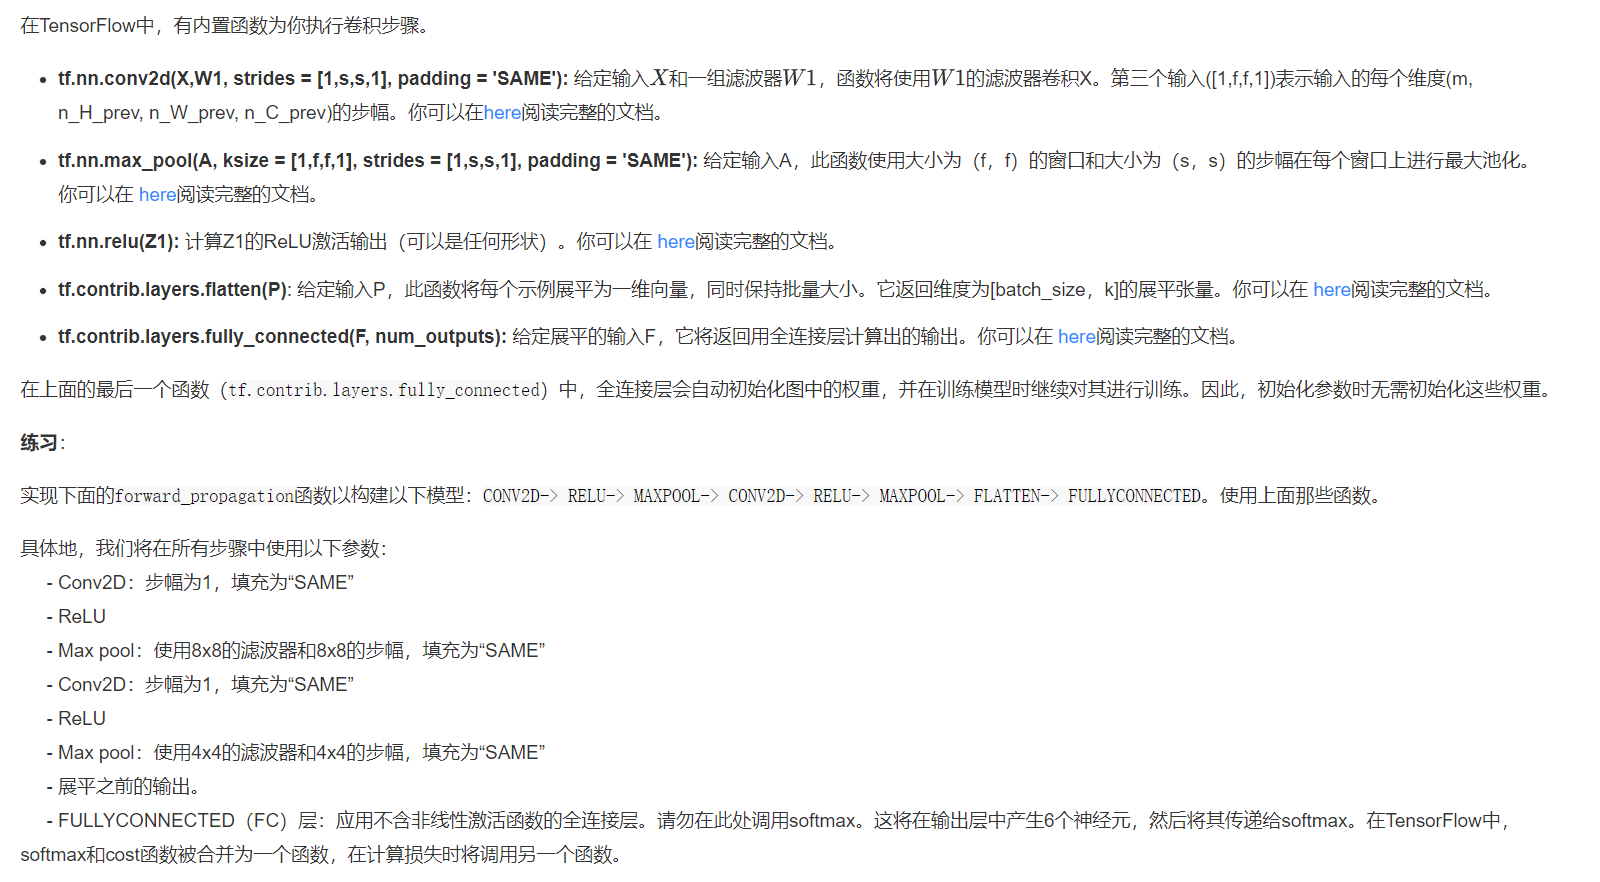

In [54]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """

    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    ### START CODE HERE ###
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None"
    Z3 = tf.contrib.layers.fully_connected(P2, num_outputs = 6, activation_fn=None)
    ### END CODE HERE ###


    return Z3

- 使用“tf.contrib.layers.flatten(P2)”时，可能会报错“AttributeError: module 'tensorflow' has no attribute 'contrib'”，将tf.contrib全部替换成tf.compat.v1.estimator就行了。[参考](http://t.csdn.cn/eeIEc)

In [55]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2,64,64,3), Y: np.random.randn(2,6)})
    print("Z3 = " + str(a))

AttributeError: module 'tensorflow_estimator.python.estimator.api._v1.estimator' has no attribute 'layers'

- 我：这里是要解决环境问题，解决起来比较复杂，直接忽略，看懂代码就行。

**预期输出**:

Z3 = [[ 1.4416984 -0.24909666 5.450499 -0.2618962 -0.20669907 1.3654671 ]
[ 1.4070846 -0.02573211 5.08928 -0.48669922 -0.40940708 1.2624859 ]]

#### 1.4 计算损失
在下面实现损失函数的计算，你可能会发现以下两个函数很有帮助：
- tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y): 计算softmax熵损失，该函数会计算softmax激活函数以及由此产生的损失。你可以在 here查看完整的文档。
- tf.reduce_mean: 计算张量各维度上元素的均值，用它来对所有训练示例的损失求和，以获得总损失，你可以在here查看完整的文档。

**练习**：使用上面的函数计算下述损失。

In [56]:
# GRADED FUNCTION: compute_cost 

def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y))
    ### END CODE HERE ###
    
    return cost

In [57]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, {X: np.random.randn(4,64,64,3), Y: np.random.randn(4,6)})
    print("cost = " + str(a))

AttributeError: module 'tensorflow_estimator.python.estimator.api._v1.estimator' has no attribute 'layers'

**预期输出**:

cost =2.91034

#### 1.5 构建模型
最后，你将合并以上实现的辅助函数以构建模型并在SIGNS数据集上对其进行训练。

你已经在课程2的“优化算法”编程作业中实现了random_mini_batches()，记住此函数返回的是一个小批次的处理列表。

**练习**：完成以下函数：

以下模型应：
- 创建占位符
- 初始化参数
- 正向传播
- 计算损失
- 创建优化函数

最后，你将创建一个会话并为num_epochs运行一个for循环，获取小批次处理，然后针对每个小批次运行优化函数。

In [59]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3 = forward_propagation(X, parameters)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z3, Y)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                ### END CODE HERE ###
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

运行以下单元格以训练模型100个epoch。检查第0和第5个阶段之后的损失是否与我们的输出匹配。如果不是，请停止单元格并检查你的代码！

In [60]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

AttributeError: module 'tensorflow_estimator.python.estimator.api._v1.estimator' has no attribute 'layers'

**预期输出**：

Cost after epoch 0: 1.921332

Cost after epoch 5: 1.904156

Cost after epoch 10: 1.904309

Cost after epoch 15: 1.904477

Cost after epoch 20: 1.901876

Cost after epoch 25: 1.784077

Cost after epoch 30: 1.681052

Cost after epoch 35: 1.618207

Cost after epoch 40: 1.597972

Cost after epoch 45: 1.566707

Cost after epoch 50: 1.554486

Cost after epoch 55: 1.502187

Cost after epoch 60: 1.461035

Cost after epoch 65: 1.304477

Cost after epoch 70: 1.201501

Cost after epoch 75: 1.144230

Cost after epoch 80: 1.098368

Cost after epoch 85: 1.077411

Cost after epoch 90: 1.043173

Cost after epoch 95: 1.022620

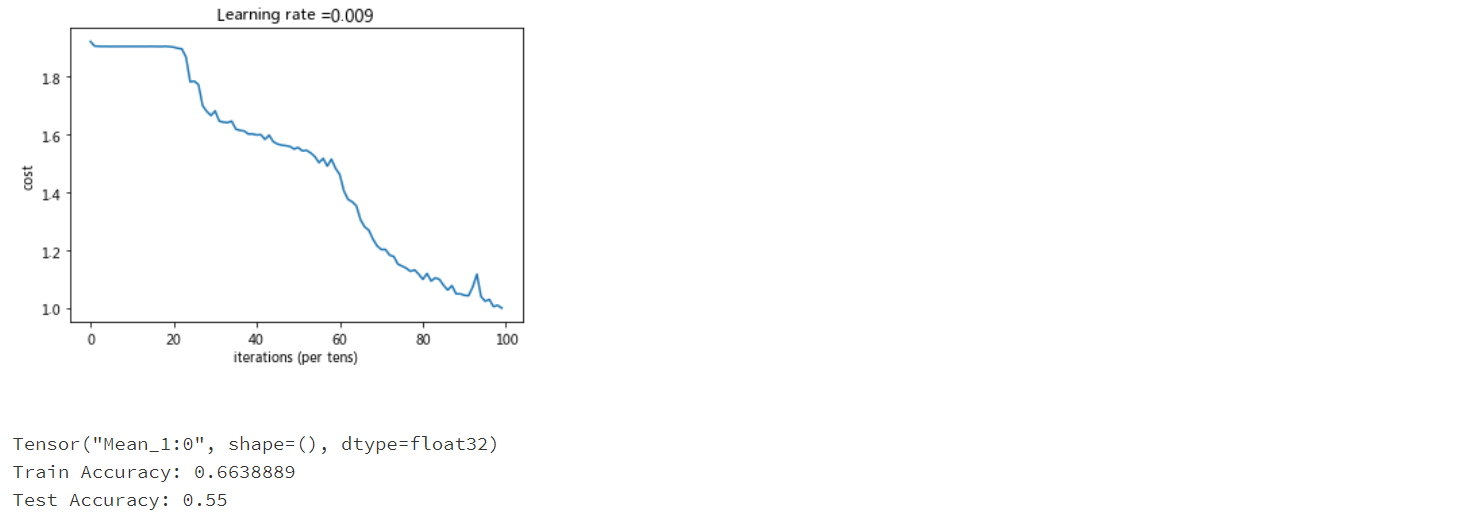

**预期输出**:

尽管它可能无法完美匹配，但是你的预期输出应该接近我们的预期，并且你的损失值应该降低。
Cost after epoch 0: 1.921332
Cost after epoch 5: 1.904156
...
Cost after epoch 0: 1.921332
Cost after epoch 5: 1.904156

Train Accuracy: 0.6638889
Test Accuracy: 0.55

Nice！你已经完成了作业并建立了一个模型，该模型可以在测试集上以几乎80％的精度识别SIGN手势，如果你愿意，可以随时使用此数据集。实际上，你可以通过花费更多时间调整超参数或使用正则化来提高其准确性（因为该模型显然具有很高的方差）。